In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
# Import data
path = './Predicting total cases VN (univariate)/assets/Total_cases.csv'
data = pd.read_csv(path)
data["Date"] = pd.to_datetime(data["Date"])
index_data = data.set_index(["Date"], drop=True)

In [4]:
sess2 = index_data.iloc[42:, :]
sess2_data = sess2.iloc[:, :1].to_numpy()
sess2_data = np.reshape(sess2_data, len(sess2_data))
sess2_data = sess2_data.tolist()

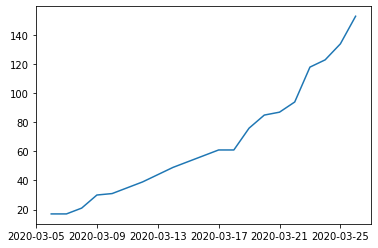

In [5]:
plt.plot(sess2)

In [27]:
rolling_mean = sess2.rolling(window = 7).mean()
rolling_std = sess2.rolling(window = 7).std()

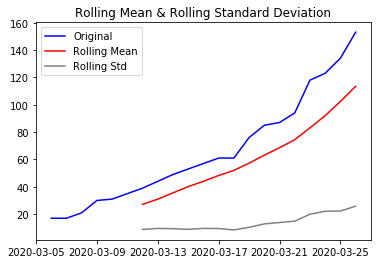

In [28]:
plt.plot(sess2, color='blue', label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='grey', label='Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [29]:
result = adfuller(sess2['Case'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: 2.200776475374452
p-value: 0.9988831432920909
Critical Values:
	1%: -3.9644434814814815
	5%: -3.0849081481481484
	10%: -2.6818144444444445


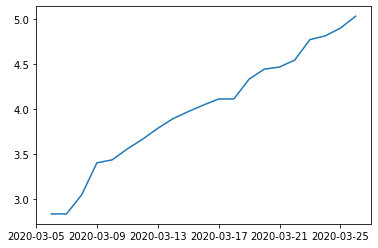

In [30]:
sess2_log = np.log(sess2)
plt.plot(sess2_log)

In [31]:
def get_stationarity(data):
    
    # rolling statistics
    rolling_mean = data.rolling(window = 7).mean()
    rolling_std = data.rolling(window = 7).std()
    
    # rolling statistics plot
    original = plt.plot(data, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(data['Case'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

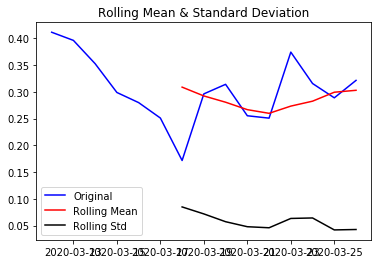

ADF Statistic: -2.300723642874399
p-value: 0.17173468850798163
Critical Values:
	1%: -4.331573
	5%: -3.23295
	10%: -2.7487


In [36]:
rolling_mean = sess2_log.rolling(window=7).mean()
sess2_log_minus_mean = sess2_log - rolling_mean
sess2_log_minus_mean.dropna(inplace=True)
get_stationarity(sess2_log_minus_mean)

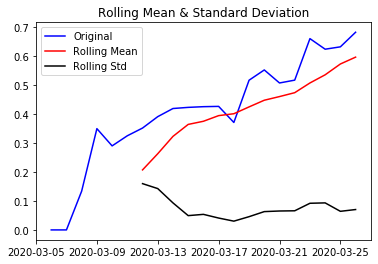

ADF Statistic: 0.47213733745259434
p-value: 0.9840011721527838
Critical Values:
	1%: -3.9644434814814815
	5%: -3.0849081481481484
	10%: -2.6818144444444445


In [33]:
rolling_mean_exp_decay = sess2_log.ewm(halflife=7, min_periods=0, adjust=True).mean()
sess2_log_exp_decay = sess2_log - rolling_mean_exp_decay
sess2_log_exp_decay.dropna(inplace=True)
get_stationarity(sess2_log_exp_decay)

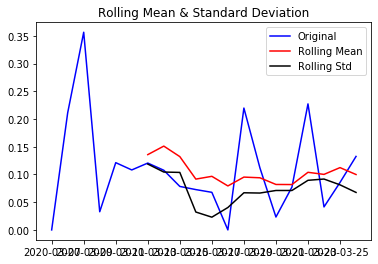

ADF Statistic: -20.334794081649818
p-value: 0.0
Critical Values:
	1%: -4.223238279489106
	5%: -3.189368925619835
	10%: -2.729839421487603


In [35]:
sess2_log_shift = sess2_log - sess2_log.shift()
sess2_log_shift.dropna(inplace=True)
get_stationarity(sess2_log_shift)

/Users/thainam/.pyenv/versions/3.7.6/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/thainam/.pyenv/versions/3.7.6/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


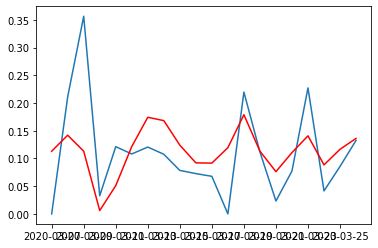

In [37]:
decomposition = seasonal_decompose(sess2_log) 
model = ARIMA(sess2_log, order=(2,1,2))
results = model.fit(disp=-1)
plt.plot(sess2_log_shift)
plt.plot(results.fittedvalues, color='red')

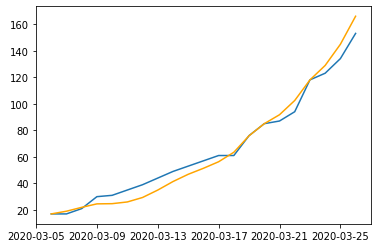

In [41]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(sess2_log['Case'].iloc[0], index=sess2_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(sess2)
plt.plot(predictions_ARIMA, color='orange')

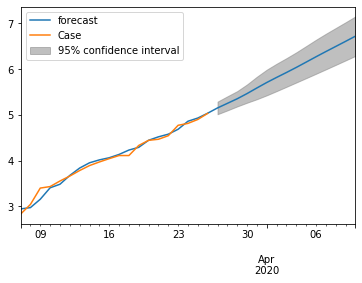

In [61]:
pred = results.plot_predict(1, (21 + 14))

In [52]:
print(results)

In [53]:
predictions_ARIMA

Date
2020-03-06     17.000000
2020-03-07     19.035366
2020-03-08     21.940206
2020-03-09     24.567869
2020-03-10     24.717945
2020-03-11     26.011616
2020-03-12     29.374180
2020-03-13     34.971250
2020-03-14     41.381701
2020-03-15     46.851433
2020-03-16     51.372843
2020-03-17     56.305979
2020-03-18     63.454990
2020-03-19     75.891731
2020-03-20     84.995352
2020-03-21     91.727849
2020-03-22    102.458785
2020-03-23    117.958503
2020-03-24    128.864428
2020-03-25    144.801741
2020-03-26    165.934751
dtype: float64

In [58]:
results.predict(1, 34)

2020-03-07    0.113085
2020-03-08    0.142022
2020-03-09    0.113119
2020-03-10    0.006090
2020-03-11    0.051014
2020-03-12    0.121573
2020-03-13    0.174410
2020-03-14    0.168312
2020-03-15    0.124143
2020-03-16    0.092128
2020-03-17    0.091691
2020-03-18    0.119530
2020-03-19    0.178977
2020-03-20    0.113289
2020-03-21    0.076229
2020-03-22    0.110635
2020-03-23    0.140872
2020-03-24    0.088428
2020-03-25    0.116605
2020-03-26    0.136229
2020-03-27    0.118725
2020-03-28    0.099738
2020-03-29    0.100091
2020-03-30    0.113517
2020-03-31    0.122404
2020-04-01    0.119123
2020-04-02    0.110720
2020-04-03    0.107283
2020-04-04    0.110782
2020-04-05    0.115549
2020-04-06    0.116360
2020-04-07    0.113602
2020-04-08    0.111162
2020-04-09    0.111419
Freq: D, dtype: float64